In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [3]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

In [4]:
GSD_IR = Table.read(fits.open('/Volumes/Vince_CLEAR/IR_cat/20150520_prior_catalogs_pgh_gs_irac_ch1.cat.fits'), format = 'fits').to_pandas()
GND_IR = Table.read(fits.open('/Volumes/Vince_CLEAR/IR_cat/20150520_prior_catalogs_pgh_gn_irac_ch1.cat.fits'), format = 'fits').to_pandas()

In [5]:
def Match_galaxy(gal_ra, gal_dec, gal_z500, gal_id, cat_ra, cat_dec):

    r = (1. / 60 / 60) * 0.5       

    z500= []
    ids = []
    dr = []

    for i in range(len(cat_ra)):
        cosr = np.sin(np.radians(cat_dec[i])) * np.sin(np.radians(gal_dec)) + np.cos(np.radians(cat_dec[i]))\
                * np.cos(np.radians(gal_dec)) * np.cos(np.radians(cat_ra[i]) - np.radians(gal_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
       
        z500.append(gal_z500[np.argwhere(rad == min(rad))[0]][0])
        ids.append(gal_id[np.argwhere(rad == min(rad))[0]][0])    
        dr.append(min(rad))
    return z500, ids, dr

In [6]:
SIR_z500, SIR_ids, SIR_dr = Match_galaxy(v4S.ra.values, v4S.dec.values,v4S.z500.values, v4S.id.values, GSD_IR.RA, GSD_IR.DEC)
NIR_z500, NIR_ids, NIR_dr = Match_galaxy(v4N.ra.values, v4N.dec.values,v4N.z500.values, v4N.id.values, GND_IR.RA, GND_IR.DEC)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


In [7]:
Sz = []
Sf = []
Si = []
Sr = []
for i in mdb.query('field == "GSD"').index:
    if mdb.id[i] in SIR_ids:
        if np.array(GSD_IR.F24.values)[SIR_ids == mdb.id[i]][0] > 0:
            Sz.append(np.array(SIR_z500)[SIR_ids == mdb.id[i]][0])
            Sf.append(np.array(GSD_IR.F24.values)[SIR_ids == mdb.id[i]][0])
            Si.append(mdb.id[i])
            Sr.append(np.array(SIR_dr)[SIR_ids == mdb.id[i]][0])
Nz = []
Nf = []
Ni = []
Nr = []
for i in mdb.query('field == "GND"').index:
    if mdb.id[i] in NIR_ids:
        if np.array(GND_IR.F24.values)[NIR_ids == mdb.id[i]][0] > 0:
            Nz.append(np.array(NIR_z500)[NIR_ids == mdb.id[i]][0])
            Nf.append(np.array(GND_IR.F24.values)[NIR_ids == mdb.id[i]][0])
            Ni.append(mdb.id[i])
            Nr.append(np.array(NIR_dr)[NIR_ids == mdb.id[i]][0])


(0.5, 2.5)

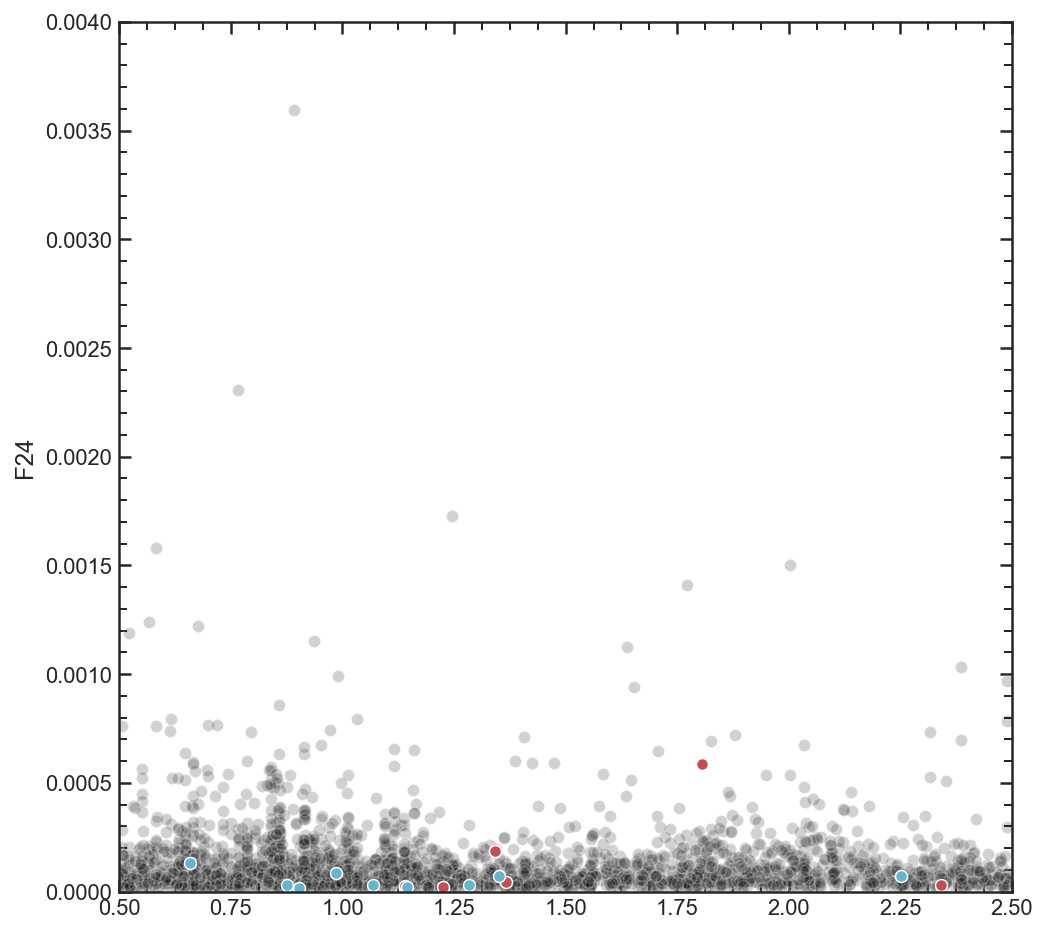

In [8]:
plt.figure(figsize=[8,8])

sea.scatterplot(SIR_z500,GSD_IR.F24, color = 'k', alpha = 0.2)
sea.scatterplot(NIR_z500,GND_IR.F24, color = 'k', alpha = 0.2)

sea.scatterplot(Sz, Sf, color = 'r')
sea.scatterplot(Nz, Nf, color = 'c')
plt.ylim(0,0.004)
plt.xlim(0.5,2.5)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


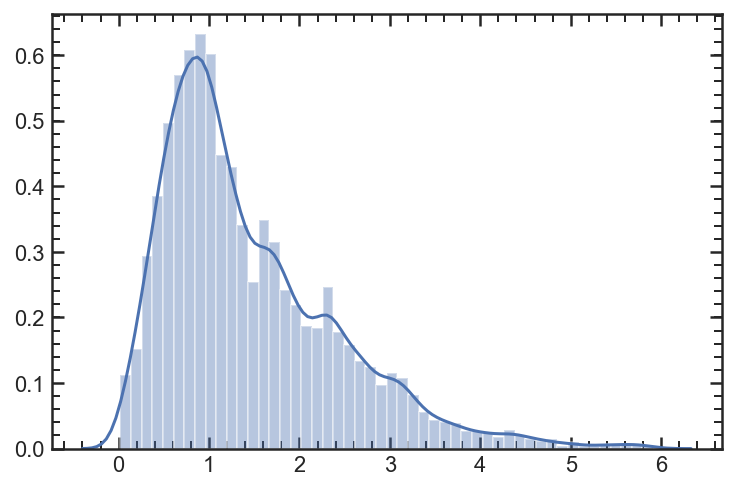

In [9]:
sea.distplot(np.append(np.array(SIR_z500)[np.array(SIR_z500) > 0],np.array(NIR_z500)[np.array(NIR_z500) > 0]))

In [55]:
Si

[40862, 48464, 35774, 38785, 45775, 44042]

# check images

In [42]:
f125 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')
f125_img = f125[0].data
f160 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')
f160_img = f160[0].data

irac1 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-_SEDS1/GOODS-S_SEDS1_sci_sub.fits')
irac1_img = irac1[0].data
irac2 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_SEDS2/GOODS-S_SEDS2_sci_sub.fits')
irac2_img = irac2[0].data
irac3 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_irac3/GOODS-S_irac3_s2_sci.fits')
irac3_img = irac3[0].data
irac4 = fits.open('/Volumes/Vince_CLEAR/IR_img/GOODS-S_irac4/GOODS-S_irac4_s1_sci.fits')
irac4_img = irac4[0].data

mips = fits.open('/Volumes/Vince_CLEAR/IR_img/s_mips_1_s1_v0.30_sci.fits')
mips_img = mips[0].data

In [43]:
wf1 = wcs.WCS(f125[0].header)
wf2 = wcs.WCS(f160[0].header)

w1 = wcs.WCS(irac1[0].header)
w2= wcs.WCS(irac2[0].header)
w3= wcs.WCS(irac3[0].header)
w4= wcs.WCS(irac4[0].header)

wm= wcs.WCS(mips[0].header)

In [71]:
D = (6 * u.arcsec * (1*u.arcmin/(60*u.arcsec)) * (1*u.deg/(60*u.arcmin))).value
ra=v4S.query('id == 45775').ra.values[0]
dec=v4S.query('id == 45775').dec.values[0]

def get_positions(ra, dec, D, W):
    [Of, Lf, Hf]=W.wcs_world2pix([[ra ,dec],[ra+D ,dec-D], [ra-D ,dec+D]],1)
    Of -= np.array([int(Lf[0]),int(Lf[1])])
    Lf = Lf.astype(int)
    Hf = Hf.astype(int)
    return Of, Lf, Hf

Of1, Lf1, Hf1 = get_positions(ra, dec, D, wf1)
Of2, Lf2, Hf2 = get_positions(ra, dec, D, wf2)

O1, L1, H1 = get_positions(ra, dec, D, w1)
O2, L2, H2 = get_positions(ra, dec, D, w2)
O3, L3, H3 = get_positions(ra, dec, D, w3)
O4, L4, H4 = get_positions(ra, dec, D, w4)

Om, Lm, Hm = get_positions(ra, dec, D, wm)

In [72]:
gal_imgf1 = f125_img[Lf1[1] : Hf1[1]+1 , Lf1[0] : Hf1[0]+1]
gal_imgf2 = f160_img[Lf2[1] :Hf2[1]+1, Lf2[0] :Hf2[0]+1]

gal_img1 = irac1_img[L1[1] :H1[1]+1, L1[0] :H1[0]+1]
gal_img2 = irac2_img[L2[1] :H2[1]+1, L2[0] :H2[0]+1]
gal_img3 = irac3_img[L3[1] :H3[1]+1, L3[0] :H3[0]+1]
gal_img4 = irac4_img[L4[1] :H4[1]+1, L4[0] :H4[0]+1]

gal_imgm = mips_img[Lm[1] :Hm[1]+1, Lm[0] :Hm[0]+1]

In [46]:
def RS_img(img):
    IMG = np.array(img) + 100

    m = np.percentile(IMG, 5)
    M = np.percentile(IMG, 99)

    IMG -= m
    IMG[IMG <= 0] = 0
    IMG /= (M-m)
    IMG[IMG > 1] =1
#     IMG[IMG**2 > 1]
    return np.arcsinh(IMG)
#     return IMG

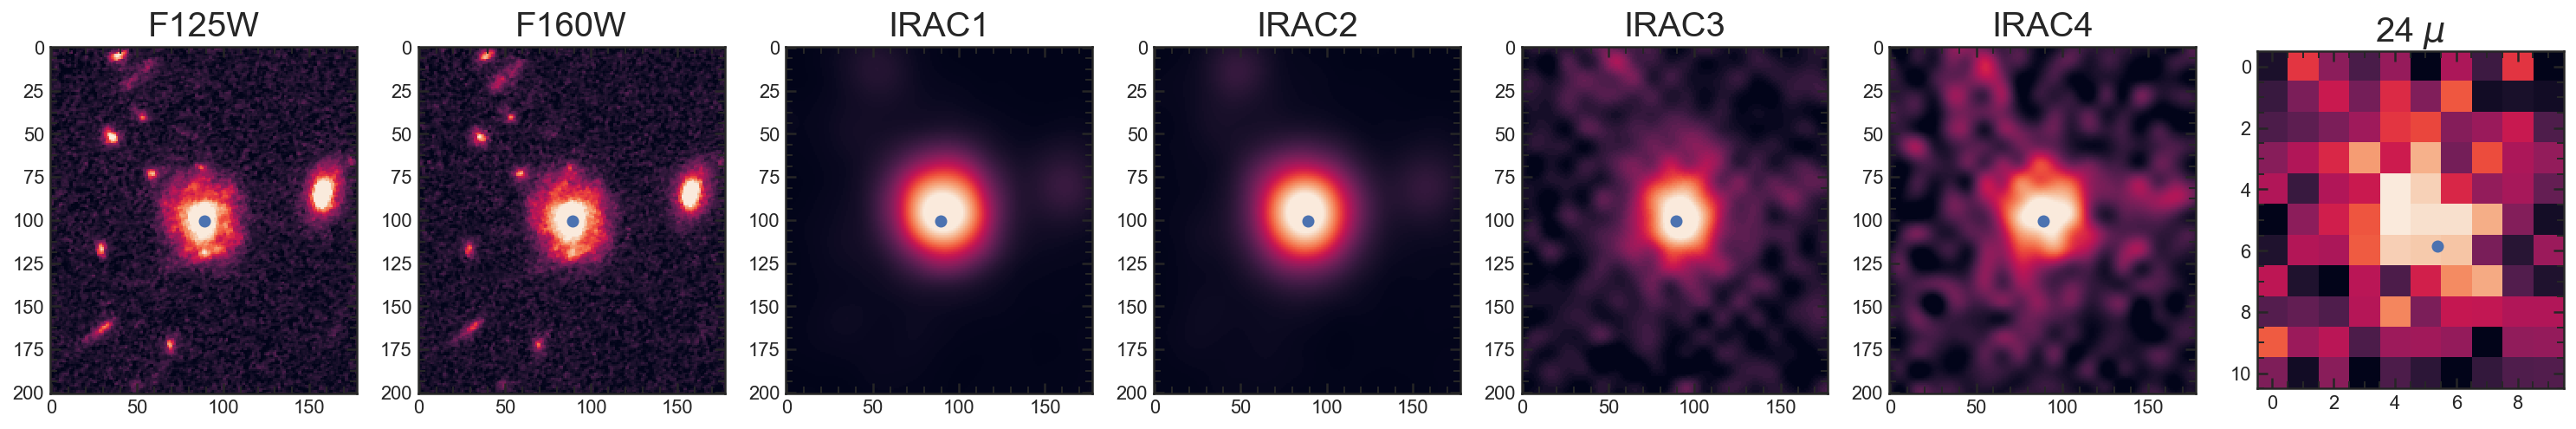

In [73]:
gs = gridspec.GridSpec(1,7)

plt.figure(figsize=[26,12])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])
ax7 = plt.subplot(gs[6])

ax1.imshow(RS_img(gal_imgf1))
ax1.scatter(Of1[0],Of1[1])
ax1.set_title('F125W', fontsize=20)

ax2.imshow(RS_img(gal_imgf2))
ax2.scatter(Of2[0],Of2[1])
ax2.set_title('F160W', fontsize=20)

ax3.imshow(RS_img(gal_img1))
ax3.scatter(O1[0],O1[1])
ax3.set_title('IRAC1', fontsize=20)

ax4.imshow(RS_img(gal_img2))
ax4.scatter(O2[0],O2[1])
ax4.set_title('IRAC2', fontsize=20)

ax5.imshow(RS_img(gal_img3))
ax5.scatter(O3[0],O3[1])
ax5.set_title('IRAC3', fontsize=20)

ax6.imshow(RS_img(gal_img4))
ax6.scatter(O4[0],O4[1])
ax6.set_title('IRAC4', fontsize=20)

ax7.imshow(RS_img(gal_imgm))
ax7.scatter(Om[0],Om[1])
ax7.set_title('24 $\mu$', fontsize=20)

plt.savefig('../plots/IR_check/GSD_45775.png',bbox_inches = 'tight')

In [175]:
Xm[1]-Xm[0], Ym[1]-Ym[0]

(9, 7)

In [176]:
Xf1[1] - Xf1[0], Yf1[1] - Yf1[0]

(167, 147)

In [214]:
9/167,7/147

(0.05389221556886228, 0.047619047619047616)

In [228]:
Ym, Xm

(array([599, 608]), array([895, 905]))

In [229]:
Y1, X1

(array([11178, 11355]), array([16481, 16681]))